Trabajo por hacer: Econtrar el mejor modelo posible utilizando maximos recursos.

# Detección de anomalías cardíacas en ECG de 1 derivación






## imports

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.metrics import confusion_matrix

In [54]:
from google.colab import drive
drive.mount('/content/drive')


import os
os.chdir('/content/drive/My Drive/ML PROJECTS/ECG')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
pip install minisom

In [56]:
pip install dtaidistance

In [ ]:
from dtaidistance import dtw

# Clases utilizadas

In [ ]:
class QuantClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, quantizer='Kmeans', *args, **kwargs):
        if quantizer == 'Som':
            self.model = SomQuant(*args, **kwargs)
        elif quantizer == 'Kmeans':
            self.model = KmeansQuant(*args, **kwargs)
        else:
            raise ValueError(f"Unknown model type: {quantizer}")

    def fit(self, X, y):
        return self.model.fit(X, y)

    def update_fit(self,X,y):
      return self.model.update_fit(X,y)

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

    def probs(self):
      return self.model.probs()

    def visualize(self):
      return self.model.visualize()

    def confusion_matrix(self,X,y):
      return self.model.confusion_matrix(X,y)



In [57]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.manifold import Isomap

class KmeansQuant(BaseEstimator, ClassifierMixin):
    def __init__(self, n_centroids, radius=None,n_neighbors=5,sigma=1, distance_function=None,sensitivity=0.95,num_iterations=50):
        self.sigma = sigma
        self.distance_function = self.euclidean_distance if distance_function == None else distance_function
        self.n_centroids = n_centroids
        self.radius = radius
        self.n_neighbors = n_neighbors
        self.sensitivity = sensitivity
        self.num_iterations = num_iterations


    def fit(self, X, y):
        weights,initial_centroids = self._initial_kmeans_values(X,y)

        self.centroids,labels,min_dist = self.weighted_kmeans(X=X,initial_centroids=initial_centroids,weights=weights, distance=self.dist,max_iter=self.num_iterations)

        self.threshold = np.percentile(min_dist,self.sensitivity*100)

        self.freq_matrix = np.zeros((self.n_centroids,len(self.classes_)))

        for i in range(self.n_centroids):
          for j in range(len(self.classes_)):
             self.freq_matrix[i, j] = np.sum((labels == i) & (y == j))

        self.isomap = Isomap(radius=self.radius,n_neighbors=self.n_neighbors,metric=self.distance_function).fit(self.centroids)

        self._recalculate_prob()


    def update_fit(self,X,y):
      NN = self.isomap.nbrs_.kneighbors(X,n_neighbors=1)

      for i in range(NN.shape[0]):
        self.freq_matrix[NN[i],y[i]] += 1

      self._recalculate_prob()

    def probs(self):
      return self.prob

    def predict(self, X_pred, loss=None,priors=None,prob=False):
        # Inicializar los priors y y_pred
        priors = priors if priors is not None else np.ones((X_pred.shape[0], len(self.classes_))) / len(self.classes_)
        y_pred = np.zeros(X_pred.shape[0], dtype=int)

        # Inicializar la matriz de pérdidas
        if loss is None:
            loss_matrix = np.ones((len(self.classes_), len(self.classes_))) - np.eye(len(self.classes_))
        else:
            loss_matrix = loss

        # Calcular errores y ganadores para todas las muestras de una vez
        errors, winners = self.isomap.nbrs_.kneighbors(X_pred,n_neighbors=1)

        if prob:
          return self.prob[winners]

        # Vectorizar el cálculo de expected_loss y la asignación de y_pred
        for i in range(X_pred.shape[0]):
            if errors[i] < self.threshold:
                expected_loss = loss_matrix @ (self.prob[winners[i]] * priors[i]).T
                y_pred[i] = expected_loss.argmin()
            else:
                y_pred[i] = -1  # Supongo que esto debería ser -1 para marcarlo como no clasificado

        return y_pred


    def visualize(self):
      x = self.isomap.transform(self.centroids)
      fig, ax = plt.subplots()

      # Iterar sobre cada centroide y dibujar un diagrama de sectores
      for i in range(x.shape[0]):
          x_pos = x[i, 0]
          y_pos = x[i, 1]

          # Evitar divisiones por cero
          if np.sum(self.freq_matrix[i]) == 0:
              continue

          proportions = self.freq_matrix[i] / np.sum(self.freq_matrix[i])

          # Generar colores para las clases
          num_classes = len(proportions)
          colors = plt.colormaps.get_cmap("tab10").colors[:num_classes]  # Obtener colores para las clases

          # Dibujar el pie chart en las coordenadas (x_pos, y_pos)
          wedges, texts = ax.pie(proportions, radius=0.1, center=(x_pos, y_pos), colors=colors, startangle=90)

          # Añadir borde negro a las porciones del gráfico de pie
          for wedge in wedges:
              wedge.set_edgecolor('black')  # Borde de color negro para los gráficos de pie

      # Ajustar los límites del gráfico correctamente
      ax.set_xlim(np.min(x[:, 0]) - 0.5, np.max(x[:, 0]) + 0.5)
      ax.set_ylim(np.min(x[:, 1]) - 0.5, np.max(x[:, 1]) + 0.5)

      # Mostrar el gráfico con aspecto igual
      plt.gca().set_aspect('equal', adjustable='box')

      # Mostrar gráfico
      plt.show()

    def confusion_matrix(self,X_test,y_test,loss=None,priors=None):
      confusion_matrix = np.zeros((len(self.classes_),len(self.classes_)))
      y_pred = self.predict(X_test,loss,priors)

      for i in range(X_test.shape[0]):
        confusion_matrix[int(y_test[i])][int(y_pred[i])] += 1

      return confusion_matrix


    def _recalculate_prob(self):
      self.prob = np.zeros((self.n_centroids,len(self.classes_)), dtype=np.float64)

      for i in range(len(self.classes_)):
        for x in range(self.centroids.shape[0]):
            #influencia de este nodo en los demas
            self.prob[:,i] += self.freq_matrix[x,i]*np.exp(-self.isomap.dist_matrix_[x]/self.sigma)

      normalizacion = np.sum(self.prob, axis=1)

      for i in range(self.prob.shape[1]):
          self.prob[:,i] = self.prob[:, i] / normalizacion[i]


    def _initial_kmeans_values(self,X,y):
      self.classes_ = np.unique(y)
      proporcion = {cls: np.sum([y == cls]) / len(y) for cls in self.classes_}
      weights = np.array([proporcion[cls] for cls in y])

      centroids_per_class = np.round(np.array(list(proporcion.values())) * self.n_centroids).astype(int)

      # Ajuste para asegurar que el total sea correcto
      while centroids_per_class.sum() != self.n_centroids:
          if centroids_per_class.sum() > self.n_centroids:
            centroids_per_class[np.argmax(centroids_per_class)] -= 1
          else:
            centroids_per_class[np.argmin(centroids_per_class)] += 1

      # Inicialización de centroides
      initial_centroids = []
      for cls, n in zip(self.classes_, centroids_per_class):
        cls_data = X[y == cls]
        centroid = cls_data.mean(axis=0)
        if n > 1:
            noise = np.random.normal(scale=0.1, size=(n, cls_data.shape[1]))
            cls_centroids = centroid + noise
        else:
          cls_centroids = centroid.reshape(1, -1)
        initial_centroids.append(cls_centroids)
      initial_centroids = np.vstack(initial_centroids)

      return weights,initial_centroids


    def weighted_kmeans(self,X, initial_centroids, weights,distance,max_iter=3000, tol=1e-4):
      centroids = initial_centroids
      n_samples = X.shape[0]

      for i in range(max_iter):
          print("iteracion ", i)
          # Calcular distancias entre puntos y centroides usando la métrica especificada
          distances = distance(X, centroids)

          # Asignar cada punto al centroide más cercano
          labels = np.argmin(distances, axis=1)


          # Calcular nuevos centroides ponderados por los pesos
          new_centroids = []
          for i in range(centroids.shape[0]):
              # Seleccionar puntos en el cluster i
              mask = (labels == i)
              if np.any(mask):
                  # Calcular centroide ponderado
                  weighted_sum = np.sum(weights[mask][:, np.newaxis] * X[mask], axis=0)
                  new_centroid = weighted_sum / np.sum(weights[mask])
                  new_centroids.append(new_centroid)
              else:
                  # Si un cluster se queda sin puntos, reasignar aleatoriamente
                  new_centroids.append(X[np.random.choice(n_samples)])

          new_centroids = np.array(new_centroids)

          # Verificar la convergencia
          if np.all(np.linalg.norm(new_centroids - centroids, axis=1) < tol):
              break

          centroids = new_centroids

      min_dist = np.min(distances,axis=1)

      return centroids, labels, min_dist



    def dist(self, X, W):
      n_samples = X.shape[0]
      n_centroids = W.shape[0]
      dis = np.zeros((n_samples, n_centroids))

      for i in range(n_samples):
          for j in range(n_centroids):
              dis[i][j] = self.distance_function(X[i], W[j])

      return dis


    @staticmethod
    def euclidean_distance(x, w):
        return np.linalg.norm(x - w)


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from minisom import MiniSom
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import floyd_warshall
import matplotlib.gridspec as gridspec

class SomQuant(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neurons, m_neurons, input_len, sigma=1, learning_rate=0.5,
                 neighborhood_function='gaussian',
                 num_iterations=50, distance_function=None,sensitivity=0.95):
        self.sigma = sigma
        self.num_iterations = num_iterations
        self.distance_function = distance_function
        self.neighborhood_function = neighborhood_function
        self.learning_rate = learning_rate
        self.input_len = input_len
        self.n_neurons = n_neurons
        self.m_neurons = m_neurons
        self.num_iterations = num_iterations
        self.distance_function = distance_function if distance_function else self.euclidean_distance
        self.sensitivity = sensitivity

    def _assign_initial_grid(self, X, y,som):
        class_indices = {cls: np.where(y == cls)[0] for cls in self.classes_}
        class_data = {cls: X[class_indices[cls]] for cls in self.classes_}
        n_classes = len(self.classes_)
        n_samples_per_class = (self.n_neurons * self.m_neurons) // n_classes
        class_assignments = np.zeros((self.n_neurons, self.m_neurons), dtype=int)
        class_counts = {cls: 0 for cls in self.classes_}

        cls = 0
        for x in range(self.n_neurons):
            for y in range(self.m_neurons):
                class_assignments[x, y] = cls
                class_counts[cls] += 1
                if class_counts[cls] >= n_samples_per_class and cls < n_classes - 1:
                    cls += 1


        for cls in self.classes_:
            np.random.shuffle(class_data[cls])
            data_idx = 0
            for x in range(self.n_neurons):
                for y in range(self.m_neurons):
                    if class_assignments[x, y] == cls and data_idx < len(class_data[cls]):
                        som._weights[x, y, :] = class_data[cls][data_idx]
                        data_idx += 1

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        som = MiniSom(self.n_neurons,self.m_neurons, self.input_len,sigma=self.sigma,
                           learning_rate=self.learning_rate,
                           neighborhood_function=self.neighborhood_function,
                           activation_distance=self.dist, random_seed=0,
                           topology='rectangular')


        self._assign_initial_grid(X, y,som)
        rus = RandomUnderSampler(random_state=42)
        X_res,_ = rus.fit_resample(X, y)

        som.train(X_res, self.num_iterations, verbose=True)

        self.centroids = som.get_weights()

        # Reshape centroids to (n**2, m)
        centroids_reshape = self.centroids.transpose(2, 0, 1).reshape(self.centroids.shape[2], -1).transpose()

        # Initialize topological map
        self.topological_map = np.zeros((self.n_neurons, self.m_neurons, len(self.classes_)))

        self.NN = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric=self.distance_function).fit(centroids_reshape)

        self.threshold = self._calculate_topological_map(X,y)

        self._geodesic_distances()

        self._update_probs()


    def update_fit(self,X,y):


      self._update_prob()


    def visualize(self):
      fig = plt.figure(figsize=(9, 9))
      the_grid = gridspec.GridSpec(self.n_neurons, self.m_neurons, fig)

      data_counts = np.sum(self.topological_map, axis=2)

      # Normalizar los conteos de datos para usar como intensidad
      max_data_count = np.max(data_counts)
      normalized_intensity = data_counts / max_data_count  # Normalizar entre 0 y 1

      # Matriz para almacenar proporciones de clases
      label_fracs = np.zeros_like(self.topological_map, dtype=np.float64)

      # Calcular proporciones de clases en cada neurona
      for i in range(self.n_neurons):
          for j in range(self.m_neurons):
              total = np.sum(self.topological_map[i, j, :])
              if total > 0:
                  label_fracs[i, j, :] = self.topological_map[i, j, :] / total

      # Crear figura con GridSpec
      fig = plt.figure(figsize=(9, 9))
      the_grid = gridspec.GridSpec(self.n_neurons, self.m_neurons, fig)

      # Crear lista de colores basada en clases
      num_classes = len(self.classes_)  # Usamos el tamaño de self.classes en lugar de self.num_classes
      colors = plt.colormaps.get_cmap("tab10").colors[:num_classes]

      # Dibujar los gráficos de pie en cada celda de la grilla
      for i in range(self.n_neurons):
          for j in range(self.m_neurons):
              if np.sum(label_fracs[i, j, :]) > 0:  # Evita celdas vacías
                  ax = plt.subplot(the_grid[j, i], aspect=1)  # Usar j, i tal cual
                  wedges, _ = ax.pie(label_fracs[i, j, :], colors=colors, startangle=90)

                  # Normalizar la intensidad del color según el número de puntos cercanos
                  intensity = normalized_intensity[i, j]
                  color_intensity = plt.cm.Blues(intensity)  # Usamos la paleta de colores "Blues"

                  # Convertir el color al formato RGB o RGBA (si intensidad está entre 0 y 1)
                  color_intensity_rgb = color_intensity[:3]  # Tomamos solo RGB, sin canal alfa

                  # Cambiar el color del borde del gráfico de pie según la intensidad
                  for wedge in wedges:
                      wedge.set_edgecolor(color_intensity_rgb)

                  # Añadir el número de datos más cercanos sobre el gráfico de pie
                  ax.text(0, 0, f'{int(data_counts[i, j])}', color='black', ha='center', va='center', fontsize=10, weight='bold')

      # Crear leyenda correctamente
      legend_labels = [f"{cls}" for cls in self.classes_]  # Usamos las clases directamente
      plt.legend(wedges, legend_labels, bbox_to_anchor=(1.5, 1), ncol=3)

      # Mostrar el gráfico
      plt.show()
    def probs(self):
      return self.topological_map

    def predict(self, X_pred, loss=None,priors=None,prob=False):
        # Inicializar los priors y y_pred
        priors = priors if priors is not None else np.ones((X_pred.shape[0], len(self.classes_))) / len(self.classes_)
        y_pred = np.zeros(X_pred.shape[0], dtype=int)

        # Inicializar la matriz de pérdidas
        if loss is None:
            loss_matrix = np.ones((len(self.classes_), len(self.classes_))) - np.eye(len(self.classes_))
        else:
            loss_matrix = loss

        # Calcular errores y ganadores para todas las muestras de una vez
        errors, winners = self.NN.kneighbors(X_pred)

        # Obtener las coordenadas
        coordinates = np.vstack((winners[:, 0] // self.m_neurons, winners[:, 0] % self.m_neurons)).T

        if prob:
          return self.prob[coordinates[:, 0], coordinates[:, 1]]

        # Vectorizar el cálculo de expected_loss y la asignación de y_pred
        for i in range(X_pred.shape[0]):
            if errors[i] < self.threshold:
                coord = coordinates[i]
                expected_loss = loss_matrix @ (self.prob[coord[0], coord[1]] * priors[i])
                y_pred[i] = expected_loss.argmin()
            else:
                y_pred[i] = -1  # Supongo que esto debería ser -1 para marcarlo como no clasificado

        return y_pred


    def confusion_matrix(self,X_test,y_test,loss=None,priors=None):
      confusion_matrix = np.zeros((len(self.classes_),len(self.classes_)))
      y_pred = self.predict(X_test,loss,priors)

      for i in range(X_test.shape[0]):
        confusion_matrix[int(y_test[i])][int(y_pred[i])] += 1

      return confusion_matrix

    def _calculate_topological_map(self,X,y):

      QuantErrors, winners = self.NN.kneighbors(X)
      coordinates = np.vstack((winners[:, 0] // self.m_neurons, winners[:, 0] % self.m_neurons)).T
      np.add.at(self.topological_map, (coordinates[:, 0], coordinates[:, 1], y.astype(int)), 1)

      return np.percentile(QuantErrors,self.sensitivity*100)

    def _geodesic_distances(self):
      topological_graph = np.zeros((self.n_neurons * self.m_neurons, self.n_neurons * self.m_neurons))

      for i in range(self.centroids.shape[0]):
          for j in range(self.centroids.shape[1]):
              vertex = i * self.m_neurons + j
              if i - 1 >= 0:
                  topological_graph[vertex, vertex - self.m_neurons] = self.distance_function(self.centroids[i, j], self.centroids[i - 1, j])
              if j - 1 >= 0:
                  topological_graph[vertex, vertex - 1] = self.distance_function(self.centroids[i, j], self.centroids[i, j - 1])

      # Compute all-pairs shortest paths
      self.graph_distances = floyd_warshall(topological_graph, directed=False)

    def _update_probs(self):
      self.prob = np.zeros_like(self.topological_map, dtype=np.float64)

      for i in range(len(self.classes_)):
          for x in range(self.centroids.shape[0]):
              for y in range(self.centroids.shape[1]):
                  self.prob[x, y, i] += np.dot(self.topological_map[:, :, i].flatten(), np.exp(-self.graph_distances[y + x * self.centroids.shape[0]]))

      self.normalizacion = np.sum(self.prob, axis=2)

      for i in range(self.prob.shape[0]):
        for j in range(self.prob.shape[1]):
          self.prob[i, j] = self.prob[i,j] / self.normalizacion[i,j]


    def dist(self,x,w):
      dis = np.zeros((w.shape[0],w.shape[1]))
      for i in range(w.shape[0]):
        for j in range(w.shape[1]):
          dis[i][j] = self.distance_function(x,w[i][j])

      return dis

    @staticmethod
    def euclidean_distance(x, w):
        return np.linalg.norm(x - w)


In [ ]:
from dtaidistance import dtw

# utilizacion de QuantClass para detectar anomalias cardiacas
# adiciona un modelo logistico acerca de la informacion tabular a priori
# tambien se puede entrenear no supervisadamente para que mejore el modelo
# con su actividad cardiaca normal

class EcgAnomalyDetection():
  def __init__(self,loss):
    # este modelo va a estar pre entrenado usando dtw y solo como normal o anormal {0,1}
    self.quant = joblib.load("Quant.joblib")
    self.loss = loss


  # fase offline dodne se analiza su historial medica y su actividad cardiaca normal
  def fit(self,X,tabular_data):
    #prepocesar la tabular_data
    lr = joblib.load("lr.joblib")
    self.prior = lr.predict(tabular_data)
    self.quant.refit(X,np.ones(X.shape[0]))

  # fase online
  def predict(self,X):
    return self.quant.predict(X,self.loss,self.prior)

# modelo logístico de riesgo según información tabular


In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

### Manipulación de datos

In [58]:
tabular_data = pd.read_csv("cardio_train.csv",sep=";")
tabular_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [60]:
tabular_data.drop(columns=['id'], inplace=True)
tabular_data.drop_duplicates(keep = 'first', inplace = True)

columnas_numericas = ["age", "height", "weight", "ap_hi", "ap_lo"]

# Normalización Z-score
scaler = StandardScaler()
tabular_data[columnas_numericas] = scaler.fit_transform(tabular_data[columnas_numericas])

df_encoded = pd.get_dummies(tabular_data, columns=['gender', 'cholesterol', 'gluc'])

# model training
y = df_encoded['cardio']
X = df_encoded.drop('cardio', axis=1)


X_train_tabular, X_test_tabular, y_train_tabular, y_test_tabular = train_test_split(X, y, test_size=0.1, random_state=0)

### entrenamiento

In [61]:
lr = LogisticRegression()
lr.fit(X_train_tabular,y_train_tabular)

LogisticRegression()

###testeo

observamos que únicamente con información basica acerca del estado de salud y estilo de vida de la persona se puede tener una buena estimación de la afinidad a tener a una enfermedad cardíaca.

In [ ]:
print(lr.score(X_test_tabular,y_test_tabular)*100)

71.5775935981709


# Modelo de detección de anomalías en la señal de elelectrocardiograma

### Manipulacion de datos

In [62]:
df = pd.read_csv('ecg.csv')

utilizamos para entrenar una muestra con las clases balanceadas

In [63]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X = np.array(df.iloc[:, :-1])
Y = np.array(df.iloc[:, -1])

Y[Y != 0] = 1

X_train_ecg,X_test_ecg,y_train_ecg,y_test_ecg = train_test_split(X,Y)

X_train_chico = X_train_ecg[:800]
y_train_chico = y_train_ecg[:800]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_ecg, y_train_ecg)
X_resampled = X_resampled[:800]
y_resampled = y_resampled[:800]

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Función para generar una onda ECG basada en Gaussiana
def gaussian(x, mu, sigma, A):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Tiempo simulado
t = np.linspace(0, 1, 500)

# Función para generar un ECG normal con mayor variabilidad
def generate_ecg_normal():
    noise = np.random.normal(0, 0.1, len(t))  # Ruido más pronunciado
    return (gaussian(t, 0.2 + np.random.uniform(-0.02, 0.02), 0.02 + np.random.uniform(-0.005, 0.005), 1.2 + np.random.uniform(-0.2, 0.2))  # Onda P
            + gaussian(t, 0.4 + np.random.uniform(-0.02, 0.02), 0.01 + np.random.uniform(-0.005, 0.005), -0.5 + np.random.uniform(-0.2, 0.2))  # Onda Q
            + gaussian(t, 0.45 + np.random.uniform(-0.02, 0.02), 0.015 + np.random.uniform(-0.005, 0.005), 2 + np.random.uniform(-0.4, 0.4))  # Onda R
            + gaussian(t, 0.5 + np.random.uniform(-0.02, 0.02), 0.01 + np.random.uniform(-0.005, 0.005), -0.6 + np.random.uniform(-0.2, 0.2))  # Onda S
            + gaussian(t, 0.65 + np.random.uniform(-0.02, 0.02), 0.02 + np.random.uniform(-0.005, 0.005), 0.8 + np.random.uniform(-0.2, 0.2))  # Onda T
            + noise)

# Función para generar un ECG con infarto con mayor variabilidad
def generate_ecg_infarct():
    noise = np.random.normal(0, 0.1, len(t))  # Ruido más pronunciado
    st_elevation = np.where(t > 0.5, 0.4 + np.random.uniform(-0.2, 0.2), 0)  # Elevación del segmento ST más variable
    return (gaussian(t, 0.2 + np.random.uniform(-0.02, 0.02), 0.02 + np.random.uniform(-0.005, 0.005), 1.2 + np.random.uniform(-0.2, 0.2))
            + gaussian(t, 0.4 + np.random.uniform(-0.02, 0.02), 0.01 + np.random.uniform(-0.005, 0.005), -0.5 + np.random.uniform(-0.2, 0.2))
            + gaussian(t, 0.45 + np.random.uniform(-0.02, 0.02), 0.015 + np.random.uniform(-0.005, 0.005), 2 + np.random.uniform(-0.4, 0.4))
            + gaussian(t, 0.5 + np.random.uniform(-0.02, 0.02), 0.01 + np.random.uniform(-0.005, 0.005), -0.6 + np.random.uniform(-0.2, 0.2))
            - gaussian(t, 0.65 + np.random.uniform(-0.02, 0.02), 0.02 + np.random.uniform(-0.005, 0.005), 0.8 + np.random.uniform(-0.2, 0.2))  # Onda T invertida
            + st_elevation
            + noise)

# Generar muestras sintéticas
n_samples = 200  # Número de muestras por clase

ecg_normal_samples = np.array([generate_ecg_normal() for _ in range(n_samples)])
ecg_infarct_samples = np.array([generate_ecg_infarct() for _ in range(n_samples)])
synthethic_data = np.concatenate((ecg_normal_samples, ecg_infarct_samples), axis=0)
y = np.concatenate((np.zeros(n_samples), np.ones(n_samples)))

X_train_synthetic_ecg,X_test_syntethic_ecg,y_train_synthetic_ecg,y_test_synthetic_ecg = train_test_split(synthethic_data,y)



### Análisis Exploratorio

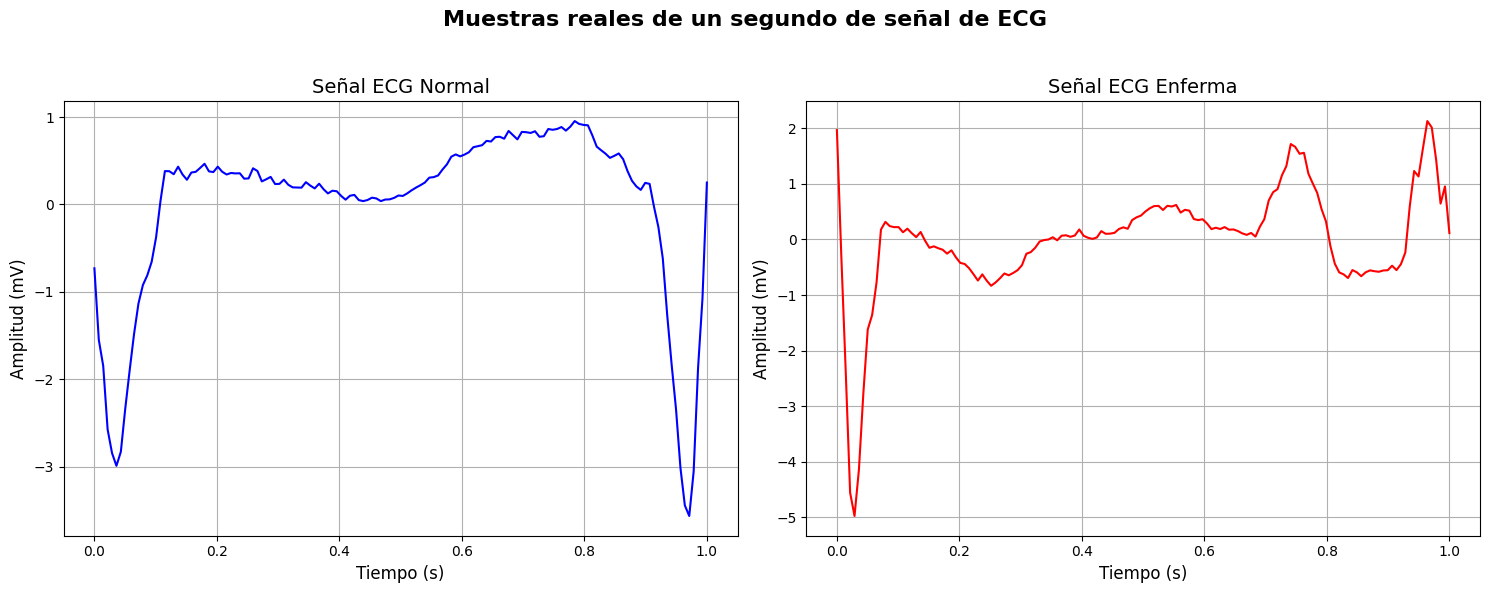

In [ ]:
t = np.linspace(0, 1, len(X_train_ecg[1]))  # Vector de tiempo

plt.figure(figsize=(15, 6))  # Hacer los gráficos más anchos

# Título general
plt.suptitle("Muestras reales de un segundo de señal de ECG", fontsize=16, fontweight='bold')

# Primera señal (normal)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(t, X_train_ecg[y_train_ecg == 0][0], color='b')
plt.title('Señal ECG Normal', fontsize=14)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Amplitud (mV)', fontsize=12)
plt.grid(True)

# Segunda señal (enferma)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(t, X_train_ecg[y_train_ecg == 1][0], color='r')
plt.title('Señal ECG Enferma', fontsize=14)
plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Amplitud (mV)', fontsize=12)
plt.grid(True)

# Ajustar el layout para que los títulos no se solapen
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

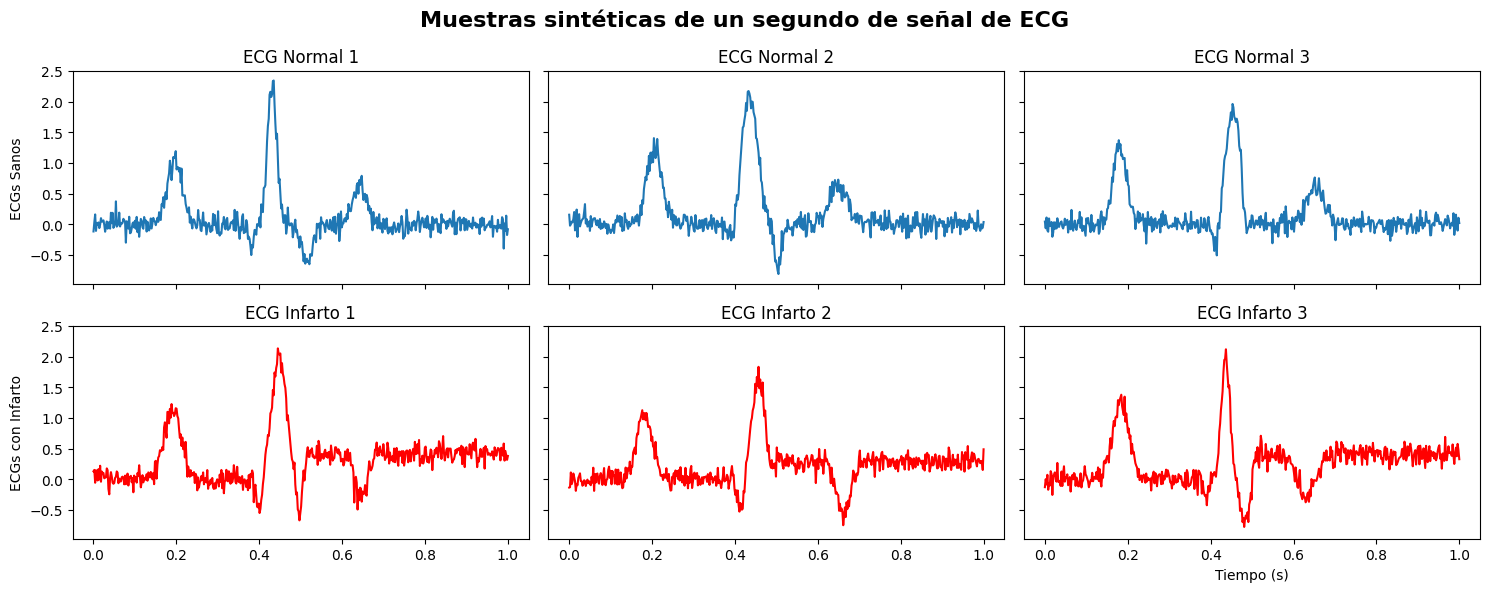

In [ ]:
# Graficar algunas muestras
fig, axes = plt.subplots(2, 3, figsize=(15, 6), sharex=True, sharey=True)
plt.suptitle("Muestras sintéticas de un segundo de señal de ECG", fontsize=16, fontweight='bold')
for i in range(3):
    axes[0, i].plot(t, ecg_normal_samples[i])
    axes[0, i].set_title(f"ECG Normal {i+1}")
    axes[1, i].plot(t, ecg_infarct_samples[i], color='r')
    axes[1, i].set_title(f"ECG Infarto {i+1}")

axes[0, 0].set_ylabel("ECGs Sanos")
axes[1, 0].set_ylabel("ECGs con Infarto")
plt.xlabel("Tiempo (s)")
plt.tight_layout()
plt.show()

### ajuste de hiperparámetros

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [ ]:
%%capture
param_grid = {"sigma":[0.1,2,3,7],"learning_rate":[0.1,0.5,1],"neighborhood_function":["gaussian","bubble","mexican_hat"]}
SQ = SomQuant(n_neurons=8,m_neurons=8,input_len=X_train_ecg.shape[1],num_iterations=1000)
cv = HalvingRandomSearchCV(SQ, param_grid)
cv.fit(X_train_ecg,y_train_ecg)

 [ 1000 / 1000 ] 100% - 0:00:00 left 

In [ ]:
cv.best_params_

{'sigma': 7, 'neighborhood_function': 'mexican_hat', 'learning_rate': 1}

In [ ]:
%%capture
param_grid = {"sigma":[1,5,0.2],"n_neighbors":[5,15,2]}
KQ = KmeansQuant(n_centroids=20)
cv = HalvingRandomSearchCV(KQ, param_grid)
cv.fit(X_train_ecg,y_train_ecg)

In [ ]:
cv.best_params_

{'sigma': 5, 'n_neighbors': 2}

## Entrenamiento

In [64]:
%%capture
KQ_real = KmeansQuant(n_centroids=35,n_neighbors=2,sigma=5,distance_function=dtw.distance_fast)
KQ_real.fit(X_train_ecg[:800],y_train_ecg[:800])

In [94]:
%%capture
KQ_synthetic = KmeansQuant(n_centroids=20,n_neighbors=2,sigma=5,distance_function=dtw.distance_fast)
KQ_synthetic.fit(X_train_synthetic_ecg,y_train_synthetic_ecg)

In [ ]:
%%capture
SQ_real = SomQuant(n_neurons=10,m_neurons=10,input_len=X_train_ecg.shape[1],num_iterations=1000,sigma = 7,neighborhood_function = "mexican_hat",learning_rate = 1, distance_function = dtw.distance_fast)
SQ_real.fit(X_train_ecg,y_train_ecg)

 [ 1000 / 1000 ] 100% - 0:00:00 left 

In [ ]:
%%capture
SQ_synthetic = SomQuant(n_neurons=8,m_neurons=8,input_len=X_train_synthetic_ecg.shape[1],num_iterations=1000,sigma = 7,neighborhood_function = "mexican_hat",learning_rate = 0.1, distance_function = dtw.distance_fast)
SQ_synthetic.fit(X_train_synthetic_ecg,y_train_synthetic_ecg)

 [ 1000 / 1000 ] 100% - 0:00:00 left 

# Testeo del modelo

## Muestra sintética

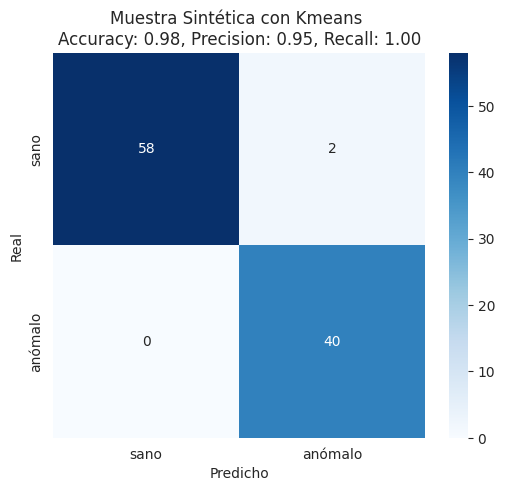

In [95]:
cm = KQ_synthetic.confusion_matrix(X_test_syntethic_ecg,y_test_synthetic_ecg)
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['sano', 'anómalo'], yticklabels=['sano', 'anómalo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f"Muestra Sintética con Kmeans \nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()


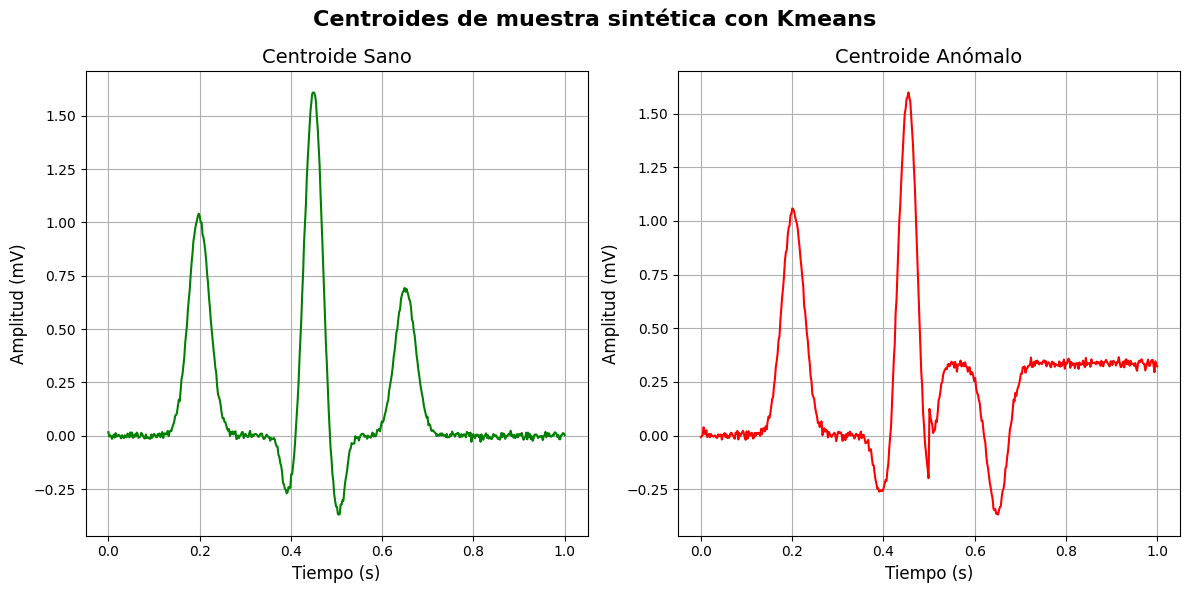

In [ ]:
centroide_sano = KQ_synthetic.centroids[np.argmax(KQ_synthetic.prob[:,0])]
centroide_anomalo = KQ_synthetic.centroids[np.argmax(KQ_synthetic.prob[:,1])]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Centroides de muestra sintética con Kmeans", fontsize=16, fontweight='bold')
# Graficar el centroide sano
axes[0].plot(np.linspace(0, 1, len(centroide_sano)), centroide_sano, color='g')
axes[0].set_title('Centroide Sano', fontsize=14)
axes[0].set_xlabel('Tiempo (s)', fontsize=12)
axes[0].set_ylabel('Amplitud (mV)', fontsize=12)
axes[0].grid(True)

# Graficar el centroide anómalo
axes[1].plot(np.linspace(0, 1, len(centroide_anomalo)), centroide_anomalo, color='r')
axes[1].set_title('Centroide Anómalo', fontsize=14)
axes[1].set_xlabel('Tiempo (s)', fontsize=12)
axes[1].set_ylabel('Amplitud (mV)', fontsize=12)
axes[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

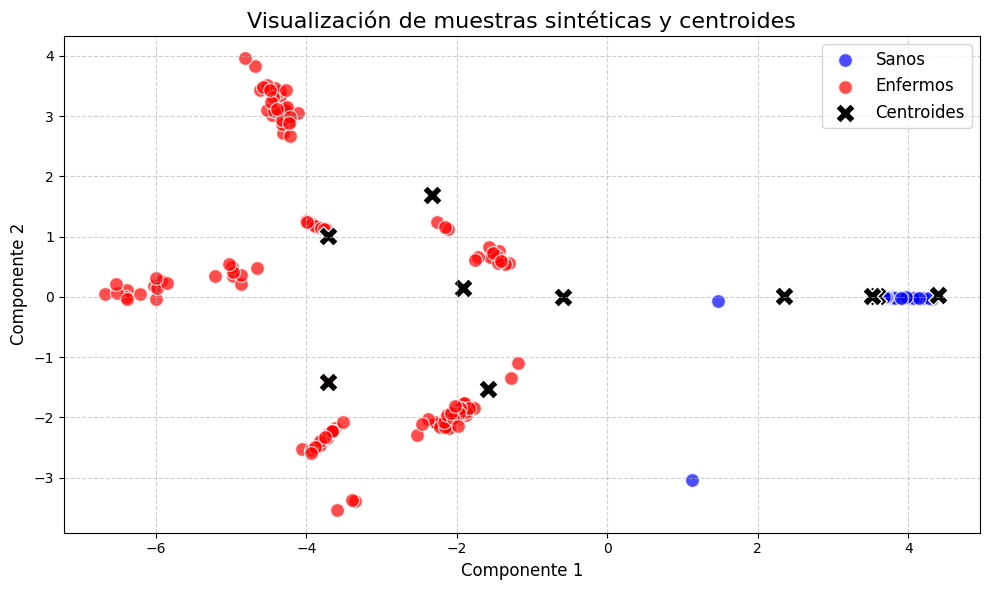

In [ ]:
embeddings = KQ_synthetic.isomap.transform(X_train_synthetic_ecg)
embeddings_centroids = KQ_synthetic.isomap.transform(KQ_synthetic.centroids)

colores = ['blue', 'red']  # Azul = Sanos (0), Rojo = Enfermos (1)

plt.figure(figsize=(10, 6))

# Graficar puntos de la clase 0 (sanos) en azul
plt.scatter(embeddings[y_train_synthetic_ecg == 0, 0], embeddings[y_train_synthetic_ecg == 0, 1],
            color=colores[0], s=100, alpha=0.7, edgecolors='w', label='Sanos')

# Graficar puntos de la clase 1 (enfermos) en rojo
plt.scatter(embeddings[y_train_synthetic_ecg == 1, 0], embeddings[y_train_synthetic_ecg == 1, 1],
            color=colores[1], s=100, alpha=0.7, edgecolors='w', label='Enfermos')

# Graficar los centroides en negro con marcador especial
plt.scatter(embeddings_centroids[:, 0], embeddings_centroids[:, 1],
            color='black', s=200, marker='X', edgecolors='white', label='Centroides')

# Añadir título y etiquetas
plt.title('Visualización de muestras sintéticas y centroides', fontsize=16)
plt.xlabel('Componente 1', fontsize=12)
plt.ylabel('Componente 2', fontsize=12)

# Mostrar leyenda
plt.legend(loc='upper right', fontsize=12)

# Mejorar la cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

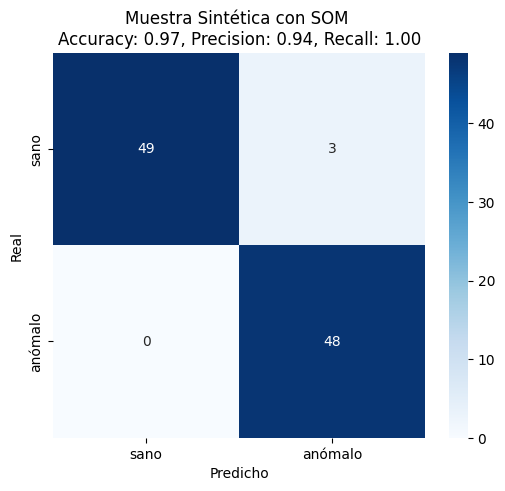

In [ ]:
cm = SQ_synthetic.confusion_matrix(X_test_syntethic_ecg,y_test_synthetic_ecg)
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['sano', 'anómalo'], yticklabels=['sano', 'anómalo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f"Muestra Sintética con SOM \nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()


<Figure size 900x900 with 0 Axes>

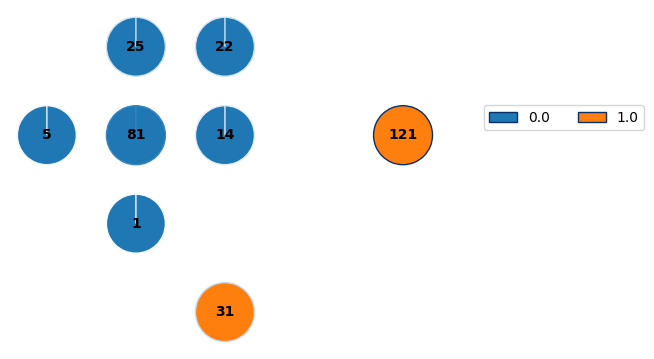

In [ ]:
SQ_synthetic.visualize()

## Muestra real

### Kmeans

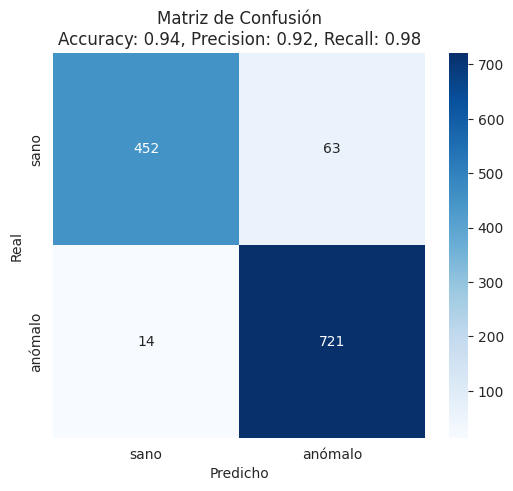

In [65]:
cm = KQ_real.confusion_matrix(X_test_ecg,y_test_ecg)
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['sano', 'anómalo'], yticklabels=['sano', 'anómalo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f"Matriz de Confusión\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()

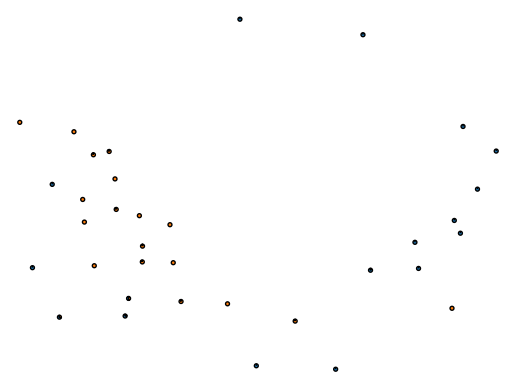

In [84]:
KQ_real.visualize()


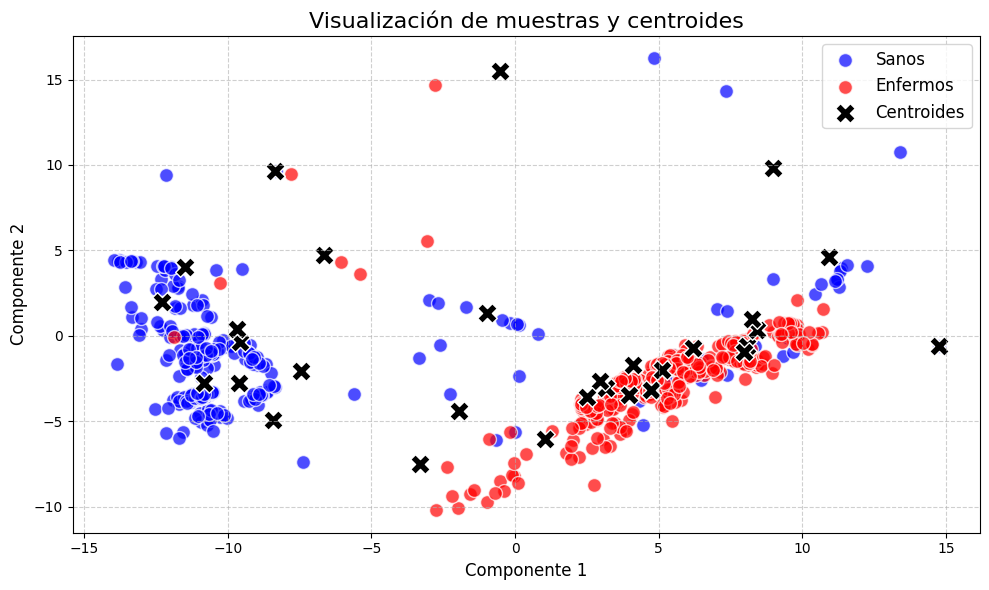

In [ ]:
embeddings = KQ_real.isomap.transform(X_train_chico)
embeddings_centroids = KQ_real.isomap.transform(KQ_real.centroids)

colores = ['blue', 'red']  # Azul = Sanos (0), Rojo = Enfermos (1)

plt.figure(figsize=(10, 6))

# Graficar puntos de la clase 0 (sanos) en azul
plt.scatter(embeddings[y_train_chico == 0, 0], embeddings[y_train_chico == 0, 1],
            color=colores[0], s=100, alpha=0.7, edgecolors='w', label='Sanos')

# Graficar puntos de la clase 1 (enfermos) en rojo
plt.scatter(embeddings[y_train_chico == 1, 0], embeddings[y_train_chico == 1, 1],
            color=colores[1], s=100, alpha=0.7, edgecolors='w', label='Enfermos')

# Graficar los centroides en negro con marcador especial
plt.scatter(embeddings_centroids[:, 0], embeddings_centroids[:, 1],
            color='black', s=200, marker='X', edgecolors='white', label='Centroides')

# Añadir título y etiquetas
plt.title('Visualización de muestras y centroides', fontsize=16)
plt.xlabel('Componente 1', fontsize=12)
plt.ylabel('Componente 2', fontsize=12)

# Mostrar leyenda
plt.legend(loc='upper right', fontsize=12)

# Mejorar la cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

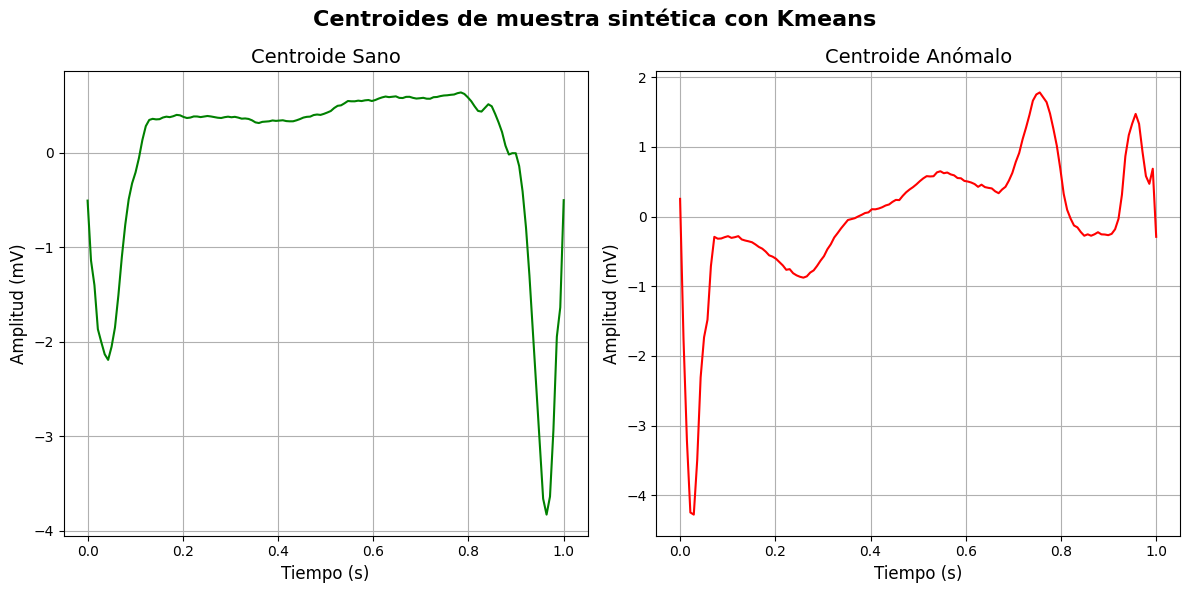

In [ ]:
centroide_sano = KQ_real.centroids[np.argmax(KQ_real.prob[:,0])]
centroide_anomalo = KQ_real.centroids[np.argmax(KQ_real.prob[:,1])]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle("Centroides de muestra real con Kmeans", fontsize=16, fontweight='bold')
# Graficar el centroide sano
axes[0].plot(np.linspace(0, 1, len(centroide_sano)), centroide_sano, color='g')
axes[0].set_title('Centroide Sano', fontsize=14)
axes[0].set_xlabel('Tiempo (s)', fontsize=12)
axes[0].set_ylabel('Amplitud (mV)', fontsize=12)
axes[0].grid(True)

# Graficar el centroide anómalo
axes[1].plot(np.linspace(0, 1, len(centroide_anomalo)), centroide_anomalo, color='r')
axes[1].set_title('Centroide Anómalo', fontsize=14)
axes[1].set_xlabel('Tiempo (s)', fontsize=12)
axes[1].set_ylabel('Amplitud (mV)', fontsize=12)
axes[1].grid(True)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

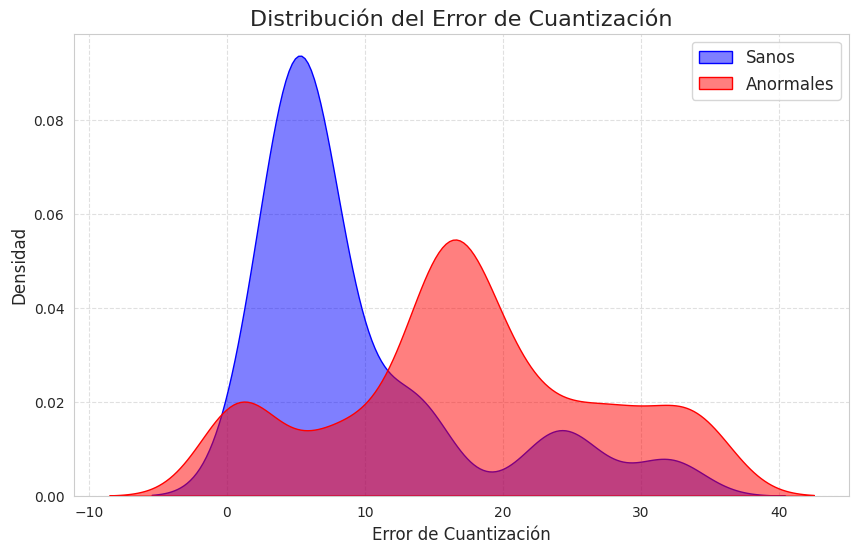

In [91]:
_,errores = KQ_real.isomap.nbrs_.kneighbors(X_train_chico,1)
errores = errores[:, 0]
errores_sanos = pd.Series(errores[y_train_chico == 0])
errores_anormales = pd.Series(errores[y_train_chico == 1])

# Configurar estilo
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

# Graficar densidades con colores específicos
sns.kdeplot(errores_sanos, fill=True, alpha=0.5, color='blue', label='Sanos')
sns.kdeplot(errores_anormales, fill=True, alpha=0.5, color='red', label='Anormales')

# Título y etiquetas
plt.title('Distribución del Error de Cuantización', fontsize=16)
plt.xlabel('Error de Cuantización', fontsize=12)
plt.ylabel('Densidad', fontsize=12)

# Leyenda y grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Mostrar el gráfico
plt.show()

### SOM

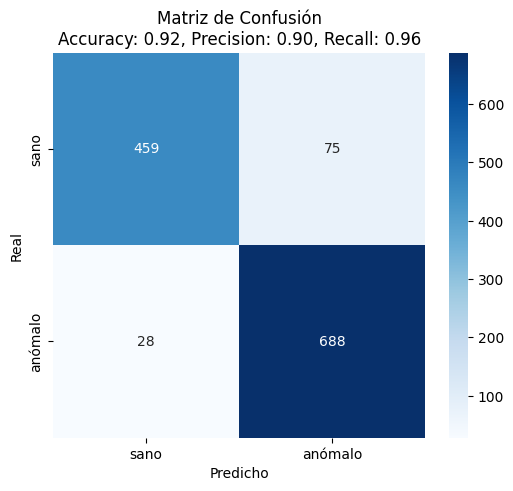

In [ ]:
cm = SQ_real.confusion_matrix(X_test_ecg,y_test_ecg)
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['sano', 'anómalo'], yticklabels=['sano', 'anómalo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f"Matriz de Confusión\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()

<Figure size 900x900 with 0 Axes>

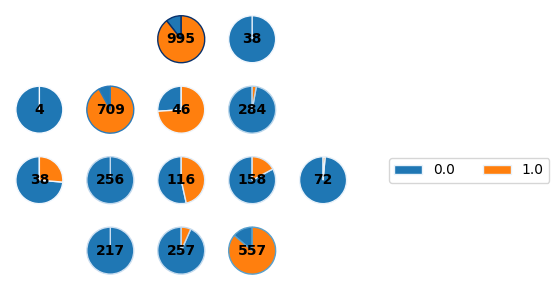

In [ ]:
SQ_real.visualize()

## Ensamble de modelos

In [72]:
X_test_ecg_sanos = X_test_ecg[y_test_ecg == 0]
X_test_ecg_anormales = X_test_ecg[y_test_ecg == 1]

X_test_tabular_sanos = X_test_tabular[y_test_tabular == 0][:X_test_ecg_sanos.shape[0]]
X_test_tabular_anormales = X_test_tabular[y_test_tabular == 1][:X_test_ecg_anormales.shape[0]]

y_ensamble = np.concatenate((np.zeros(X_test_tabular_sanos.shape[0]),np.ones(X_test_tabular_anormales.shape[0])))
X_ensamble_tabular = np.concatenate((X_test_tabular_sanos,X_test_tabular_anormales), axis=0)
X_ensamble_ecg = np.concatenate((X_test_ecg_sanos, X_test_ecg_anormales), axis=0)

In [74]:
lr_preds = lr.predict_proba(X_ensamble_tabular)[:,0].reshape(-1, 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [75]:
kq_preds = KQ_real.predict(X_ensamble_ecg,prob=True)[:,:,0]
X_train_ensamble,X_test_ensamble,y_train_ensamble,y_test_ensamble = train_test_split(np.concatenate((lr_preds,kq_preds),axis=1),y_ensamble)

In [82]:
lr_ensamble = LogisticRegression()

lr_ensamble.fit(X_train_ensamble,y_train_ensamble)

LogisticRegression()

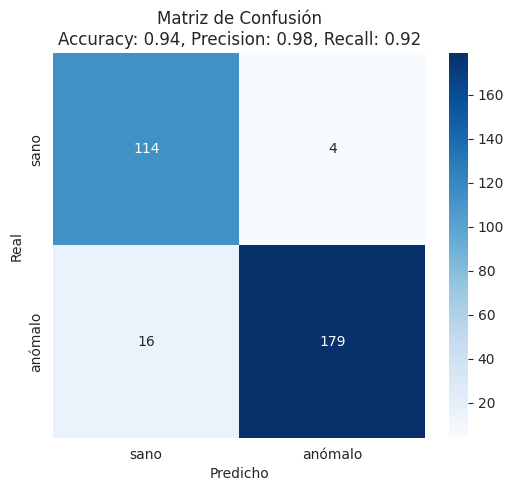

In [83]:
cm = confusion_matrix(lr_ensamble.predict(X_test_ensamble),y_test_ensamble)

accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['sano', 'anómalo'], yticklabels=['sano', 'anómalo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f"Matriz de Confusión\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()

In [ ]:
sq_preds = SQ_real.predict(X_ensamble_ecg,prob=True)[:,0].reshape(-1, 1)
X_train_ensamble,X_test_ensamble,y_train_ensamble,y_test_ensamble = train_test_split(np.concatenate((lr_preds,sq_preds),axis=1),y_ensamble)

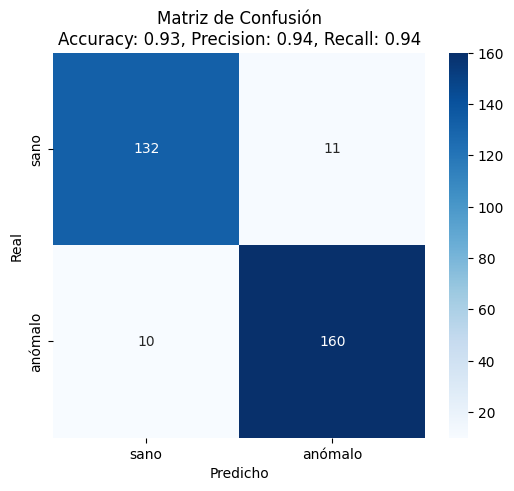

In [ ]:
cm = confusion_matrix(lr_ensamble.predict(X_test_ensamble),y_test_ensamble)
accuracy = np.trace(cm) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

# Visualización de la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=['sano', 'anómalo'], yticklabels=['sano', 'anómalo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title(f"Matriz de Confusión\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}")
plt.show()